In [1]:
%env JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

env: JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp


In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
run = 9
run_idx_length = 10_000

In [4]:
input_dir = '../datagen/unif-100k/'
output_dir = './output/run{}/unif-10k/'.format(run)

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics

import joblib
from joblib import Parallel, delayed

# from OPE_utils import *

In [6]:
PROB_DIAB = 0.2
NSTEPS = 20     # max episode length

In [7]:
nS, nA = 1442, 8
d = 21

In [8]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [9]:
# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [10]:
def load_data(fname):
    print('Loading data', fname, '...', end='')
    df_data = pd.read_csv('{}/{}'.format(input_dir, fname)).rename(columns={'State_idx': 'State'})[['pt_id', 'Time', 'State', 'Action', 'Reward']]

    # Assign next state
    df_data['NextState'] = [*df_data['State'].iloc[1:].values, -1]
    df_data.loc[(df_data['Time'] == 19), 'NextState'] = -1
    df_data.loc[(df_data['Reward'] == -1), 'NextState'] = 1440
    df_data.loc[(df_data['Reward'] == 1), 'NextState'] = 1441

    assert ((df_data['Reward'] != 0) == (df_data['Action'] == -1)).all()

    print('DONE')
    return df_data

In [11]:
def load_sparse_features(fname):
    feat_dict = joblib.load('{}/{}'.format(input_dir, fname))
    INDS_init, X, A, X_next, R = feat_dict['inds_init'], feat_dict['X'], feat_dict['A'], feat_dict['X_next'], feat_dict['R']
    return INDS_init, X.toarray(), A, X_next.toarray(), R

### va 10k eps01

In [12]:
# Remember to modify both file paths!
va_split_name = 'va10k_eps01'
N = N_val = 10_000

df_va = load_data('../eps_0_1-100k/2-features.csv').set_index('pt_id').loc[(200_000+run*run_idx_length):(200_000+run*run_idx_length+N-1)].reset_index()

vaINDS_init, vaX, vaA, vaX_next, vaR = load_sparse_features('../eps_0_1-100k/2-21d-feature-matrices.sparse.joblib')
first_ind = vaINDS_init[run*run_idx_length]
last_ind = vaINDS_init[run*run_idx_length+N]
X, A, X_next, R_ = vaX[first_ind:last_ind], vaA[first_ind:last_ind], vaX_next[first_ind:last_ind], vaR[first_ind:last_ind]

INDS_init = vaINDS_init[run*run_idx_length:run*run_idx_length+N]
X_init = vaX[INDS_init]
INDS_init -= INDS_init[0]

Loading data ../eps_0_1-100k/2-features.csv ...DONE


In [13]:
X.shape, A.shape, X_next.shape, R_.shape

((172182, 21), (172182,), (172182, 21), (172182,))

In [14]:
X_delta = X_next - X

In [15]:
import tensorflow as tf
from tensorflow import keras
from tf_utils import select_output_d, select_output

In [16]:
from OPE_utils_keras import *

## Behavior policy: predict action probabilities

In [17]:
behavior_net = learn_behavior_net(X, A, output_dir, va_split_name)

Epoch 1/100
2422/2422 [==============================] - 7s 3ms/step - loss: 1.0235 - sparse_categorical_crossentropy: 1.0235 - val_loss: 0.9199 - val_sparse_categorical_crossentropy: 0.9199
Epoch 2/100
2422/2422 [==============================] - 6s 3ms/step - loss: 0.9166 - sparse_categorical_crossentropy: 0.9166 - val_loss: 0.9096 - val_sparse_categorical_crossentropy: 0.9096
Epoch 3/100
2422/2422 [==============================] - 6s 3ms/step - loss: 0.9151 - sparse_categorical_crossentropy: 0.9151 - val_loss: 0.9078 - val_sparse_categorical_crossentropy: 0.9078
Epoch 4/100
2422/2422 [==============================] - 6s 3ms/step - loss: 0.9137 - sparse_categorical_crossentropy: 0.9137 - val_loss: 0.9064 - val_sparse_categorical_crossentropy: 0.9064
Epoch 5/100
2422/2422 [==============================] - 5s 2ms/step - loss: 0.9137 - sparse_categorical_crossentropy: 0.9137 - val_loss: 0.9039 - val_sparse_categorical_crossentropy: 0.9039
Epoch 6/100
2422/2422 [======================

In [18]:
behavior_net.summary()

Model: "behavior_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              22000     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8008      
Total params: 30,008
Trainable params: 30,008
Non-trainable params: 0
_________________________________________________________________


## Env dynamics model: predict change in state features

In [19]:
delta_net = learn_dynamics_delta_net([X,A], X_delta, output_dir, va_split_name)

Epoch 1/100
2422/2422 [==============================] - 15s 6ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 2/100
2422/2422 [==============================] - 13s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 3/100
2422/2422 [==============================] - 13s 5ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 4/100
2422/2422 [==============================] - 14s 6ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 5/100
2422/2422 [==============================] - 13s 6ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 6/100
2422/2422 [==============================] - 12s 5ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoc

In [20]:
delta_net.summary()

Model: "delta_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        [(None, 21)]         0                                            
__________________________________________________________________________________________________
hidden_layers (Sequential)      (None, 168)          190168      state_input[0][0]                
__________________________________________________________________________________________________
action_input (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
action_selection (Lambda)       (None, None)         0           hidden_layers[0][0]              
                                                                 action_input[0][0]       

## Env dynamics model: predict reward & termination

In [21]:
reward_net = learn_dynamics_reward_net(X, R_, output_dir, va_split_name)

Epoch 1/100
2422/2422 [==============================] - 6s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 3.2246e-04 - val_mean_squared_error: 3.2246e-04
Epoch 2/100
2422/2422 [==============================] - 5s 2ms/step - loss: 1.6417e-04 - mean_squared_error: 1.6417e-04 - val_loss: 1.2116e-04 - val_mean_squared_error: 1.2116e-04
Epoch 3/100
2422/2422 [==============================] - 5s 2ms/step - loss: 8.9780e-05 - mean_squared_error: 8.9780e-05 - val_loss: 2.9930e-04 - val_mean_squared_error: 2.9930e-04
Epoch 4/100
2422/2422 [==============================] - 5s 2ms/step - loss: 6.3570e-05 - mean_squared_error: 6.3570e-05 - val_loss: 7.9774e-05 - val_mean_squared_error: 7.9774e-05
Epoch 5/100
2422/2422 [==============================] - 5s 2ms/step - loss: 4.4880e-05 - mean_squared_error: 4.4880e-05 - val_loss: 1.9213e-05 - val_mean_squared_error: 1.9213e-05
Epoch 6/100
2422/2422 [==============================] - 5s 2ms/step - loss: 2.2327e-05 - mean_squared_

In [22]:
reward_net.summary()

Model: "reward_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              22000     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1001      
Total params: 23,001
Trainable params: 23,001
Non-trainable params: 0
_________________________________________________________________


## FQI

In [23]:
num_epoch = 50
Q_nets = [keras.models.load_model('{}/NFQ-clipped-keras.models/iter={}.Q_net'.format(output_dir, k), compile=False, custom_objects={'select_output': select_output}) for k in range(num_epoch+1)]
hidden_nets = [keras.models.load_model('{}/NFQ-clipped-keras.models/iter={}.hidden_net'.format(output_dir, k), compile=False) for k in range(num_epoch+1)]

## Ground-truth performance

In [24]:
# Make features for state-action pairs
X_ALL_states = []
for arrays in itertools.product(
    [[1,0], [0,1]], # Diabetic
    [[1,0,0], [0,1,0], [0,0,1]], # Heart Rate
    [[1,0,0], [0,1,0], [0,0,1]], # SysBP
    [[1,0], [0,1]], # Percent O2
    [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]], # Glucose
    [[1,0], [0,1]], # Treat: AbX
    [[1,0], [0,1]], # Treat: Vaso
    [[1,0], [0,1]], # Treat: Vent
):
    X_ALL_states.append(np.concatenate(arrays))

X_ALL_states = np.array(X_ALL_states)
X_ALL_states.shape

(1440, 21)

In [25]:
Qs = [hidden_net.predict(X_ALL_states) for hidden_net in hidden_nets]
π_list = [convert_to_policy_table(Q) for Q in Qs]

In [26]:
FQI_value_list = [hidden_net.predict(X_init).max(axis=1).mean() for hidden_net in hidden_nets]

In [27]:
true_value_list = [isd @ policy_eval_analytic(P.transpose((1,0,2)), R, π, gamma) for π in π_list]

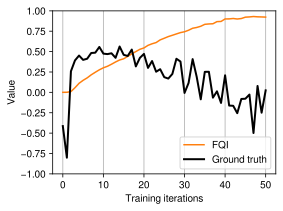

In [28]:
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(FQI_value_list, color='tab:orange', label='FQI')
plt.plot(true_value_list,  color='k', lw=2, label='Ground truth')

plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.legend()
plt.ylim(-1,1)
plt.show()

## WIS

In [29]:
features_tensor = format_features_tensor(df_va, X, INDS_init)

10000it [00:10, 910.68it/s]


In [30]:
WIS_value_list, WIS_N_list, WIS_ESS_list = zip(*Parallel(n_jobs=12)(delayed(OPE_WIS_keras)(features_tensor, k, gamma, output_dir, split=va_split_name) for k in tqdm(range(num_epoch+1))))

100%|██████████| 51/51 [00:35<00:00,  1.43it/s]


## AM

In [31]:
AM_value_list_both = Parallel(n_jobs=12)(delayed(OPE_AM_keras)(k, X_init, gamma, output_dir, split=va_split_name) for k in tqdm(range(num_epoch+1)))

100%|██████████| 51/51 [01:37<00:00,  1.92s/it]


In [32]:
_, AM_value_list = zip(*AM_value_list_both)

## FQE

In [33]:
V_X_init = Parallel(n_jobs=18)(delayed(get_FQE_value_keras)(k, X_init, output_dir, split=va_split_name) for k in tqdm(range(num_epoch+1)))
FQE_value_list = [np.nanmean(V_init) for V_init in V_X_init]

100%|██████████| 51/51 [00:08<00:00,  6.04it/s]


## WDR-FQE

In [34]:
WDR_FQE_value_list = Parallel(n_jobs=18)(delayed(OPE_WDR_FQE_keras)(features_tensor, k, gamma, output_dir, split=va_split_name) for k in tqdm(range(num_epoch+1)))

100%|██████████| 51/51 [00:19<00:00,  2.65it/s]


## Plot

In [35]:
all_values_dict = {
    'FQI_value_list': FQI_value_list,
    'WIS_value_list': WIS_value_list,
    'AM_value_list': AM_value_list,
    'FQE_value_list': FQE_value_list,
    'WDR_FQE_value_list': WDR_FQE_value_list,
    'true_value_list': true_value_list,
}

joblib.dump(all_values_dict, './results/run{}/sepsis-cont-3-va10k_eps01.values.joblib'.format(run))

['./results/run9/sepsis-cont-3-va10k_eps01.values.joblib']

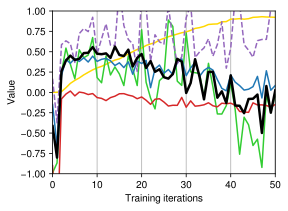

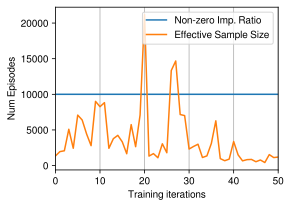

In [36]:
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(FQI_value_list, color='gold', label='FQI')
plt.plot(WIS_value_list, color='limegreen', label='WIS')
plt.plot(AM_value_list, color='tab:red', label='AM')
# plt.plot(WDR_AM_value_list, '--', color='tab:orange', label='WDR-AM')
plt.plot(FQE_value_list, color='tab:blue', label='FQE')
plt.plot(WDR_FQE_value_list, '--', color='tab:purple', label='WDR-FQE')
plt.plot(true_value_list,  color='k', lw=2.5, label='Ground truth')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.savefig('./fig/run{}/sepsis-cont-3-va10k_eps01.pdf'.format(run), bbox_inches='tight')
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(4,3))
plt.plot(WIS_N_list, label='Non-zero Imp. Ratio')
plt.plot(WIS_ESS_list, label='Effective Sample Size')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Num Episodes')
plt.xlim(0,50)
plt.legend()
plt.savefig('./fig/run{}/sepsis-cont-3-va10k_eps01-ESS.pdf'.format(run), bbox_inches='tight')
plt.show()

In [37]:
WDR_AM_value_list = np.full_like(FQI_value_list, fill_value=np.nan)
results = []
for value_list in [
    FQI_value_list, 
    WIS_value_list,
    AM_value_list,
    WDR_AM_value_list,
    FQE_value_list,
    WDR_FQE_value_list
]:
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman", 'Performance', 'Regret', 'Suboptimality'], 
    index=['FQI', 'WIS', 'AM', 'WDR-AM', 'FQE', 'WDR-FQE']
).T
df_results.to_csv('./results/run{}/sepsis-cont-3-va10k_eps01.csv'.format(run))
df_results

,FQI,WIS,AM,WDR-AM,FQE,WDR-FQE
MSE,0.399070,0.092145,0.175792,NaN,0.025765,0.367819
Spearman,-0.633032,0.690588,0.802172,NaN,0.853032,0.099276
Performance,-0.498601,0.169173,0.451421,NaN,0.556815,0.024506
Regret,1.061011,0.393236,0.110988,NaN,0.005595,0.537904
Suboptimality,1.176143,0.508369,0.226120,NaN,0.120727,0.653036
